##**Executive Summary**

* This project applies machine learning to predict Life Expectancy using a rich dataset of global health and development indicators. After rigorous preprocessing—including outlier treatment, log-transformations, and feature engineering—two models were evaluated: one with raw features, and another with log-transformed variables.

* The best model, a Random Forest Regressor using log-transformed features, achieved an excellent R² score of 0.9685 and a low MAE of 1.06, outperforming the raw feature version.

* SHAP analysis and model-based feature importance consistently highlighted HIV/AIDS prevalence, Adult Mortality, and Income Composition of Resources as the top predictors. These reflect critical healthcare and socioeconomic drivers of life expectancy worldwide.

* Additional validation with residual plots and cross-validation (R² = 0.919) confirmed that the model is accurate, stable, and generalizable.

Overall, the notebook demonstrates both strong predictive power and explainability—making it a valuable tool for public health planning, resource prioritization, and policy analysis.

###Step 1: Load and Inspect the Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Load dataset

data = pd.read_csv("/content/Life Expectancy Data.csv")

#Basic information

print(data.head())
print(data.info())
print(data.describe())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

###Step 2: Cleaning and Pre-process of the Dataset.

In [2]:
#To check the Null values

print(data.isnull().sum())

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64


In [3]:
# Create a copy to avoid modifying the original dataset
df_cleaned = data.copy()

# Drop 'Country' as it's not useful for numerical prediction
df_cleaned.drop(columns=["Country"], inplace=True)

# Convert 'Status' (Developing/Developed) to numerical (0 = Developing, 1 = Developed)
df_cleaned["Status"] = df_cleaned["Status"].map({"Developing": 0, "Developed": 1})

# Rename columns to remove leading/trailing spaces (if any)
df_cleaned.columns = df_cleaned.columns.str.strip()

# Handle missing values: Fill with column mean
df_cleaned.fillna(df_cleaned.mean(), inplace=True)

# Check if any missing values remain
missing_values = df_cleaned.isnull().sum().sum()     #gives the total number of missing values in the entire dataset

# Display the cleaned dataset's info
df_cleaned.info(), missing_values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             2938 non-null   int64  
 1   Status                           2938 non-null   int64  
 2   Life expectancy                  2938 non-null   float64
 3   Adult Mortality                  2938 non-null   float64
 4   infant deaths                    2938 non-null   int64  
 5   Alcohol                          2938 non-null   float64
 6   percentage expenditure           2938 non-null   float64
 7   Hepatitis B                      2938 non-null   float64
 8   Measles                          2938 non-null   int64  
 9   BMI                              2938 non-null   float64
 10  under-five deaths                2938 non-null   int64  
 11  Polio                            2938 non-null   float64
 12  Total expenditure   

(None, np.int64(0))

###Step 3: Exploratory Data Analysis (EDA)

1. **Correlation Heatmap**: To identify the strongest predictors of life expectancy.

In [4]:
import matplotlib.pyplot as plt

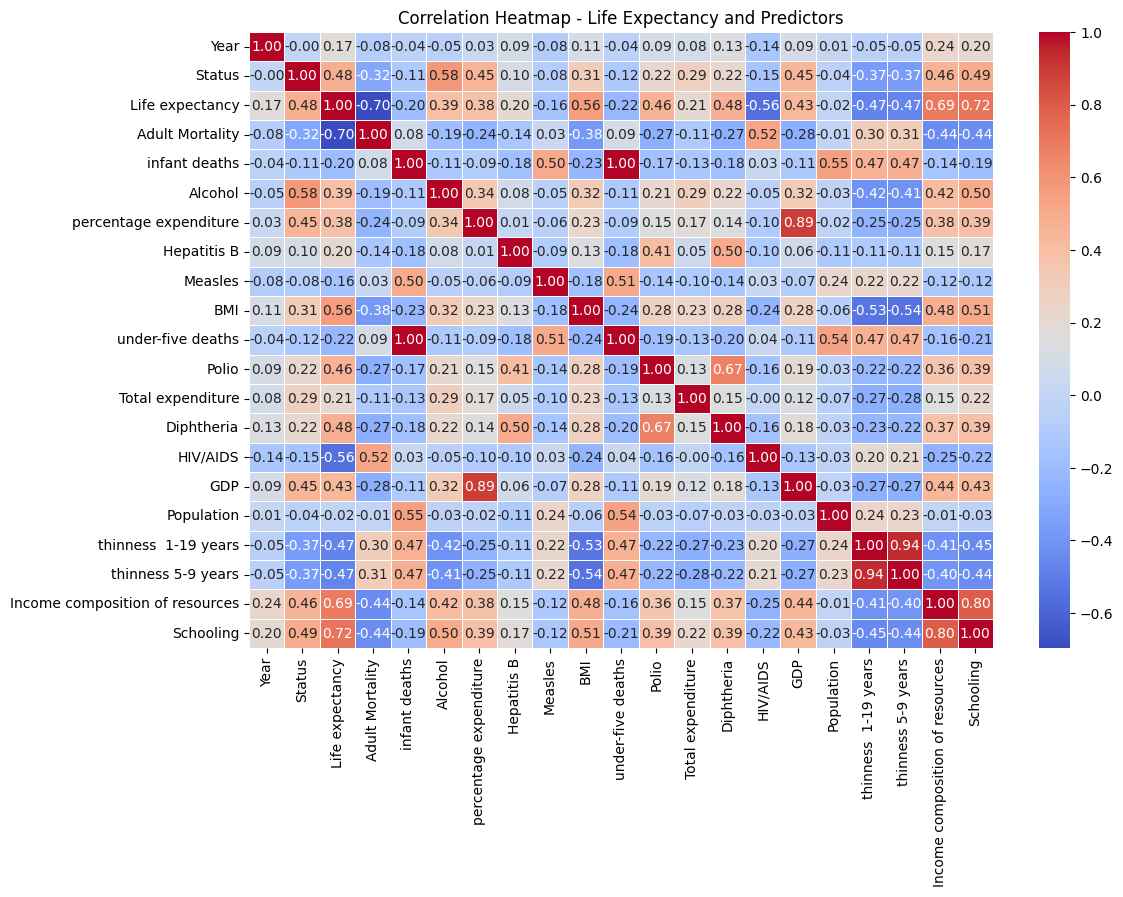

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidth=0.5)

plt.title("Correlation Heatmap - Life Expectancy and Predictors")

plt.show()

**Interactive Correlation Heatmap**

In [6]:
pip install plotly

In [7]:
import plotly.express as px

In [8]:
correlation_matrix = df_cleaned.select_dtypes(include=['number']).corr()

# Create interactive heatmap
# Changed 'color_continuous_scale' to a Plotly colorscale
fig = px.imshow(correlation_matrix,
                labels = dict(color = "Correlation"),
                x = correlation_matrix.columns,
                y = correlation_matrix.columns,
                color_continuous_scale = px.colors.sequential.RdBu)  # Use px.colors

fig.update_layout(title = "📊 Interactive Correlation Heatmap", width=800, height=800)

# Show the heatmap
fig.show()

**Conclusion:**



*  Strong Positive Correlation:
    * **Schooling (+0.72)** and **Income Composition of Resources (+0.73)** have high impact on Life Expectancy.
    * Total Healthcare Expenditure and GDP also have positive impact on life expectancy.

* Strong Negative Correlation:
  * **Adult Mortality (-0.69)** and **HIV/AIDS (-0.56)** reduce the life expectancy relatively.



2. **Distribution of Life Expectancy**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



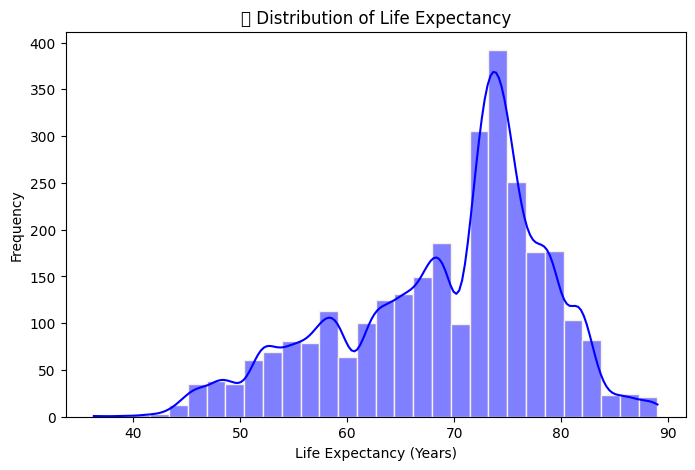

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned["Life expectancy"], bins=30, edgecolor = 'linen', alpha = 0.5, kde=True, color="blue", kde_kws = {'bw_adjust' : 0.5}, line_kws = {'color': "black"})

plt.title("📈 Distribution of Life Expectancy")
plt.xlabel("Life Expectancy (Years)")
plt.ylabel("Frequency")

plt.show()

###Step 4: Outliers Detection and Treatment

We will visualize boxplots for all numerical columns

In [10]:
# Select all numerical columns

numerical_columns = df_cleaned.select_dtypes(include=['number']).columns.tolist()

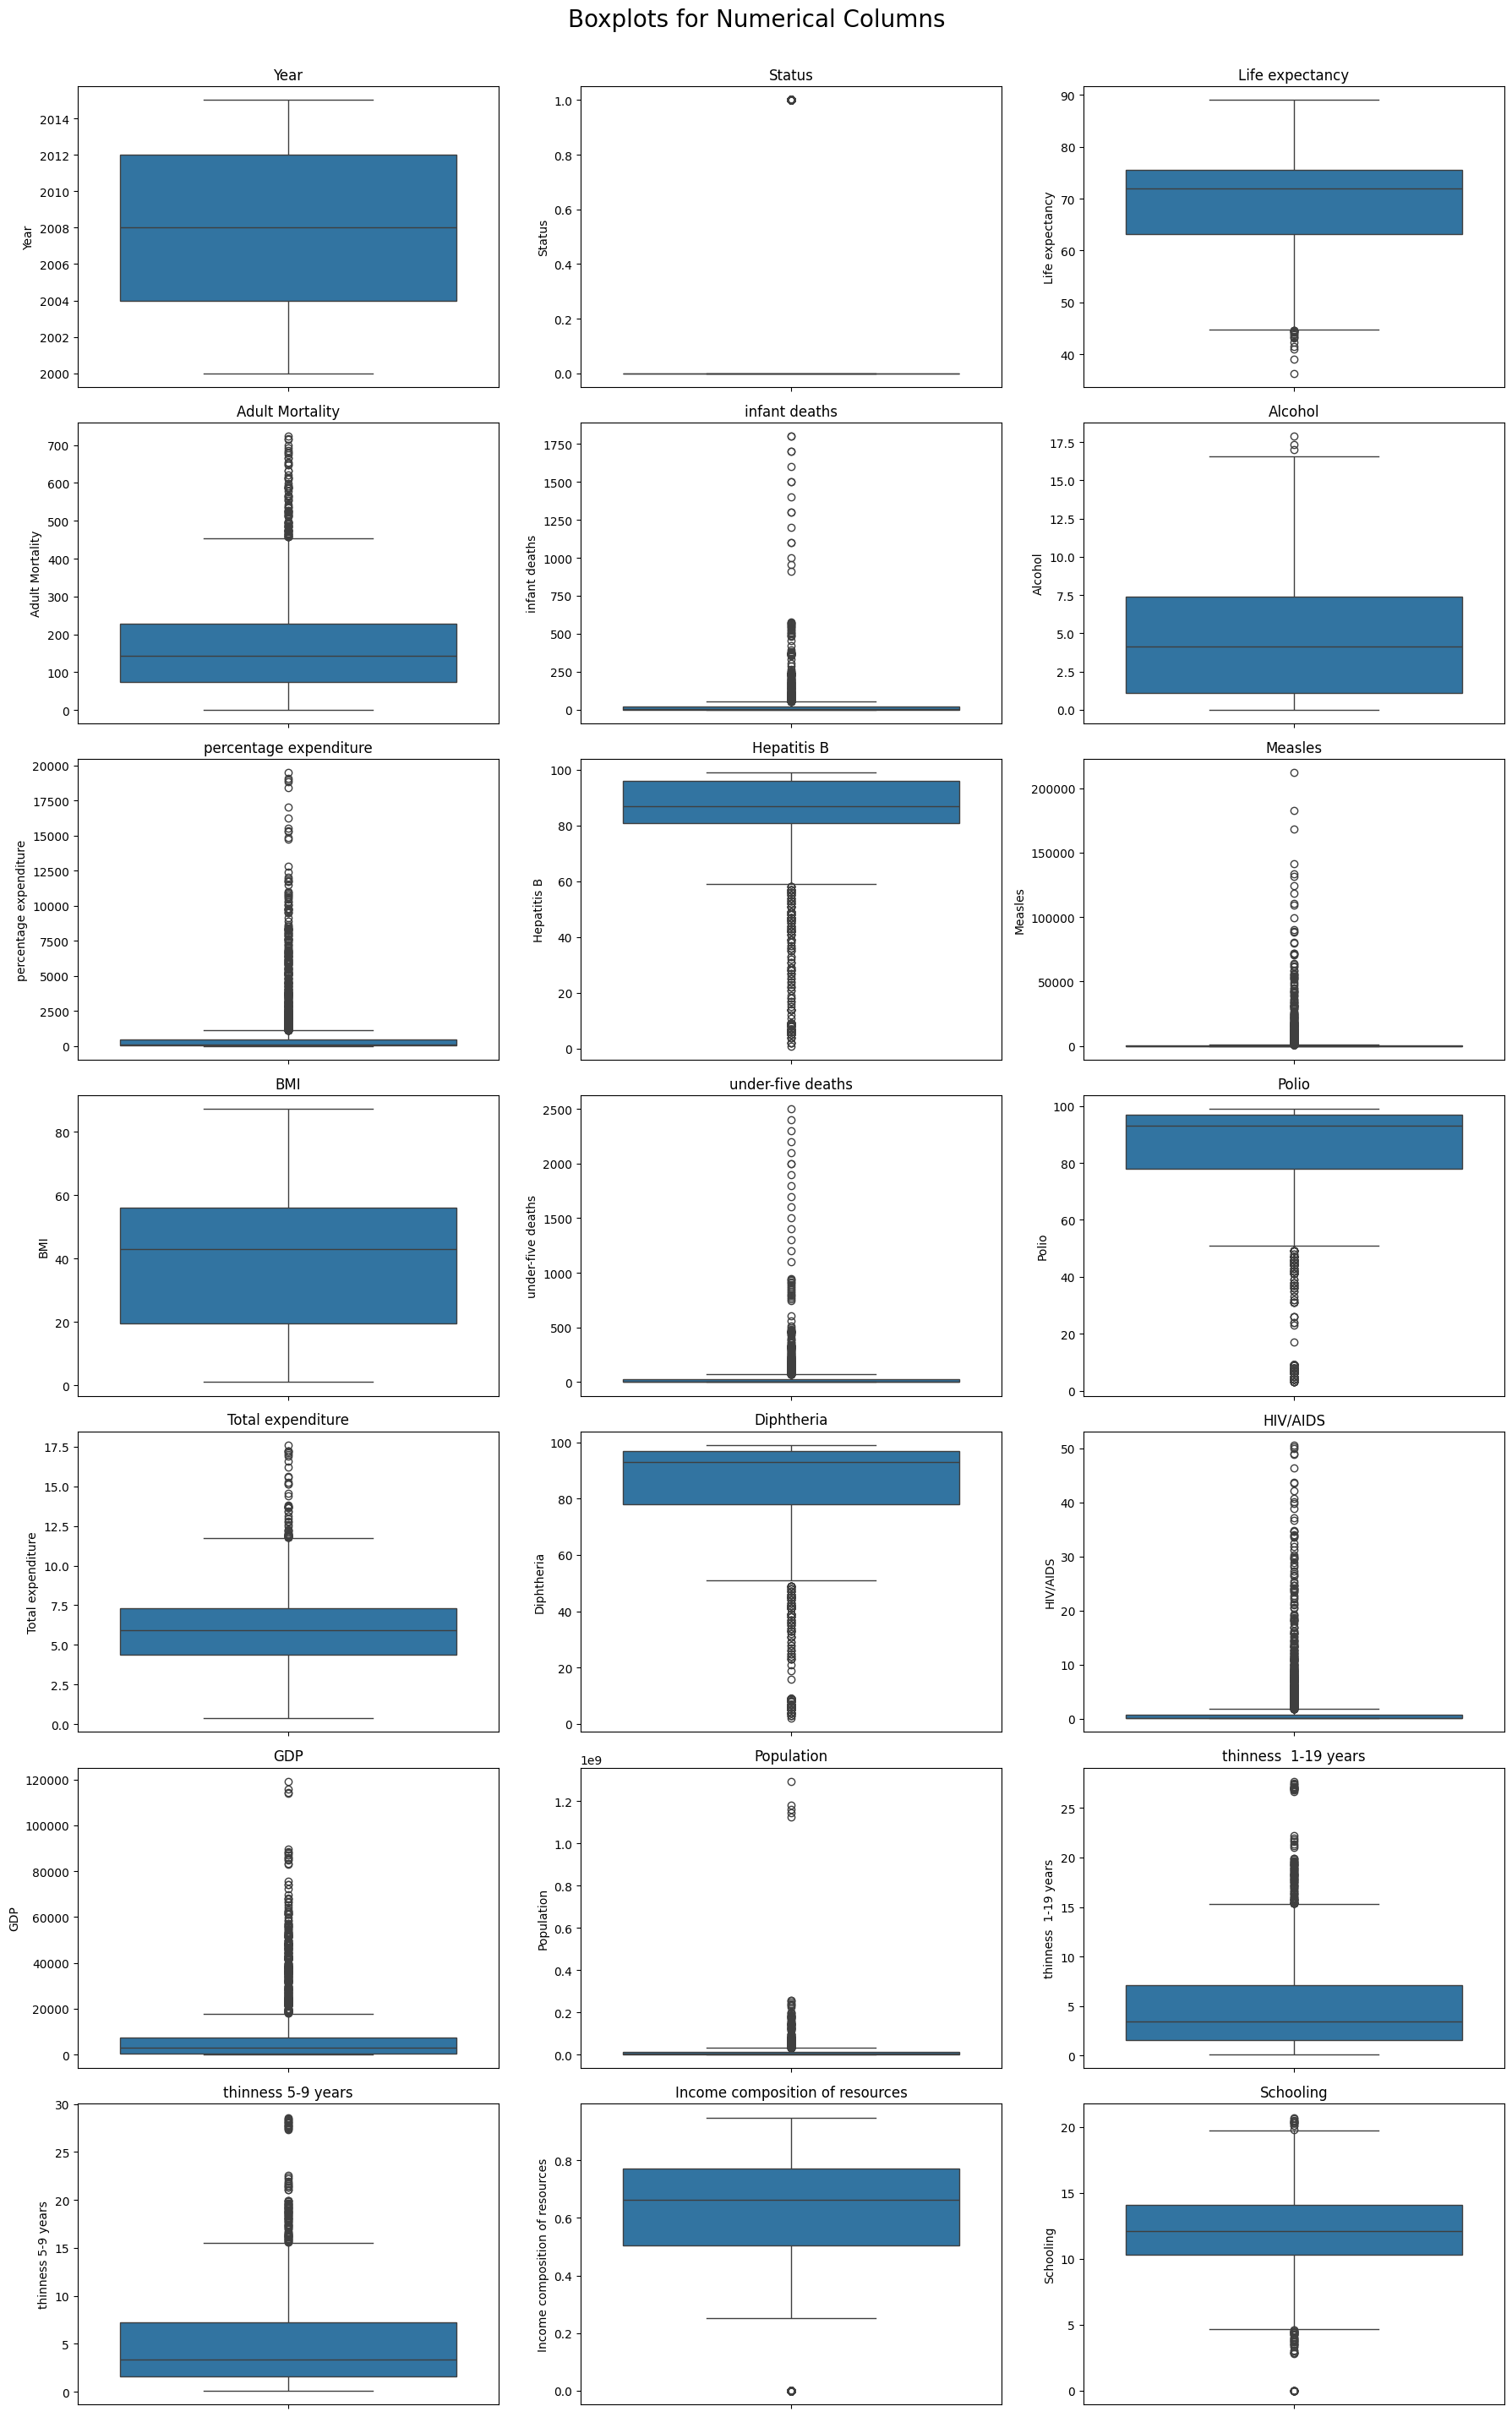

In [11]:
# Create the individual boxplots for each numerical column

num_features = len(numerical_columns)
cols = 3
rows = (num_features + cols - 1) // cols

plt.figure(figsize = (18, rows*4))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y = df_cleaned[col])
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Boxplots for Numerical Columns", fontsize = 20, y = 1.02)
plt.show()



*   Features with Clear Outliers:
      * **GDP**: Right-skewed with large outliers at the top(rich nations).
      * **Alcohol, BMI, HIV/AIDS, Adult Mortality**: Strong Variability, extreme values.
      * **Measles, Polio, Diphtheria**: Highly skewed due to vaccination campaigns - many countries with 100%, others with 0%.
      * **Infant Deaths, Under-five Deaths**: Major Outliers  - especially in low-income countries.

*   Features that appear More Stable:
      * **Schooling, Status, Income Composition of Resources**: Relatively well-distributed.
      * **Total Expenditure**: Compact, but few outliers.



###Step 5: Handle Outliers & Skew


A: Clipping extreme values (1st and 99th percentiles)

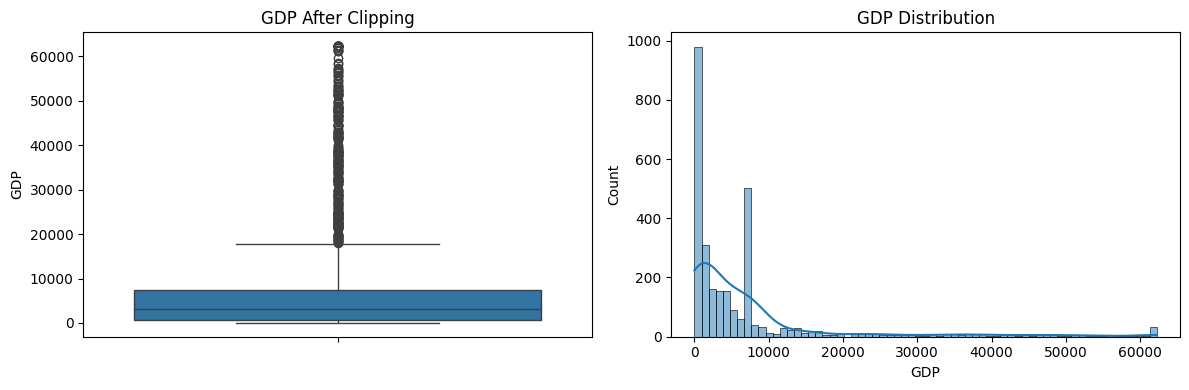

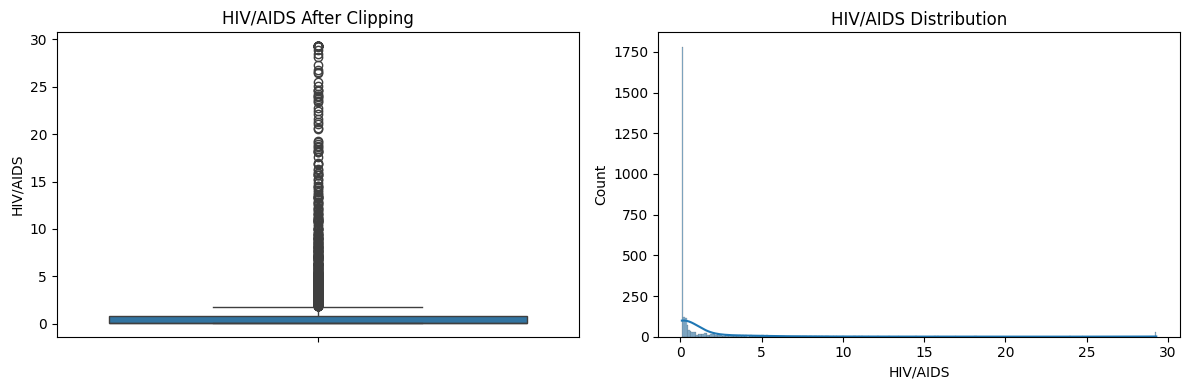

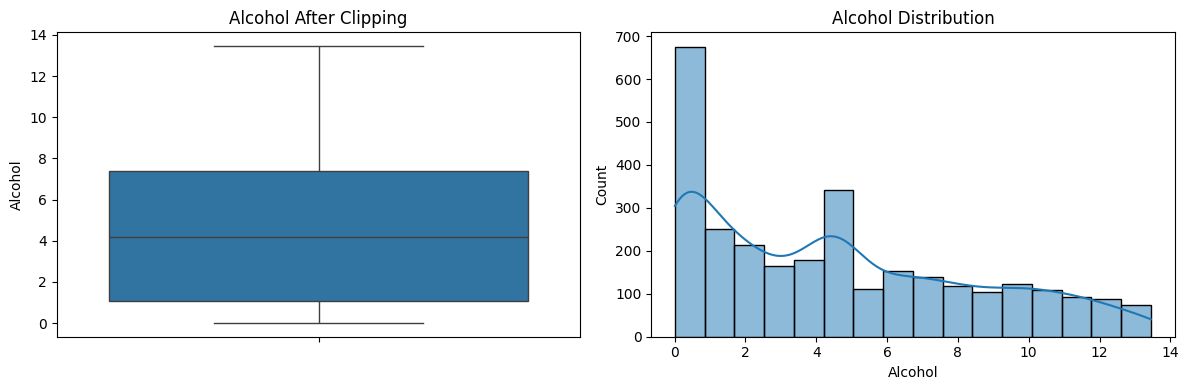

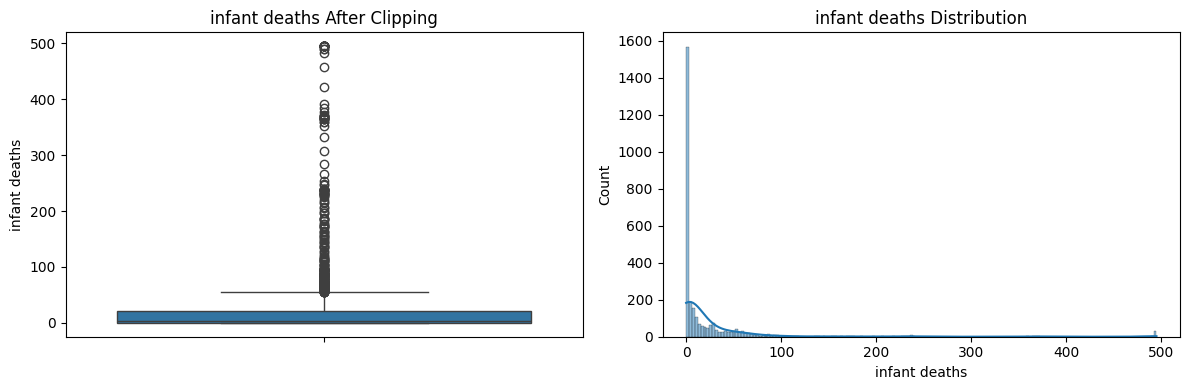

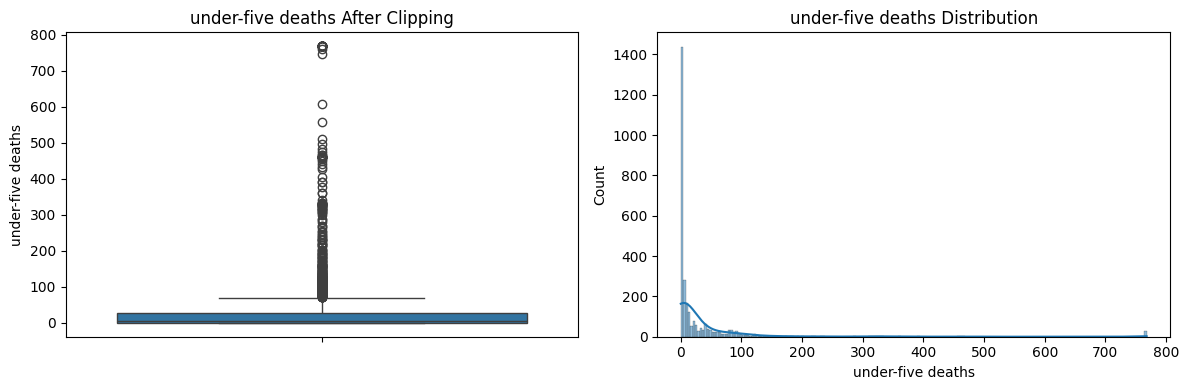

In [12]:
clip_bounds = {}
for col in df_cleaned.select_dtypes(include='number').columns:
    lower = df_cleaned[col].quantile(0.01)
    upper = df_cleaned[col].quantile(0.99)
    clip_bounds[col] = (lower, upper)
    df_cleaned[col] = df_cleaned[col].clip(lower, upper)

# Optional: Visualize before vs after for key features
# (Commented out for performance, can uncomment to view)
for col in ['GDP', 'HIV/AIDS', 'Alcohol', "infant deaths", "under-five deaths"]:
     fig, axes = plt.subplots(1, 2, figsize=(12, 4))
     sns.boxplot(y=df_cleaned[col], ax=axes[0]).set_title(f"{col} After Clipping")
     sns.histplot(df_cleaned[col], ax=axes[1], kde=True).set_title(f"{col} Distribution")
     plt.tight_layout()
     plt.show()


**Conclusion:**
 * Clipping outliers helped in reduce skew and instability.

B: Log-Transformation and Comparison of Raw and Log-transformed Features

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [14]:
#Step 1: Create the log-transformed version

df_cleaned['log_GDP'] = np.log1p(df_cleaned['GDP'])
df_cleaned['log_HIV_AIDS'] = np.log1p(df_cleaned['HIV/AIDS'])
df_cleaned['log_Alcohol'] = np.log1p(df_cleaned['Alcohol'])
df_cleaned['log_infant deaths'] = np.log1p(df_cleaned['infant deaths'])
df_cleaned['log_under-five deaths'] = np.log1p(df_cleaned['under-five deaths'])


#Step 2: Common features used in both models

base_features = ["Year", "Status", "Income composition of resources", "Schooling", "Adult Mortality", "BMI" ]
log_features = ["log_GDP", "log_HIV_AIDS", "log_Alcohol", "log_infant deaths", "log_under-five deaths"]

# Model A (Raw)
features_raw = df_cleaned[base_features + ["GDP", "HIV/AIDS", "Alcohol", "infant deaths", "under-five deaths"]]
target = df_cleaned["Life expectancy"]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features_raw, target, test_size=0.2, random_state=42)
model_raw = RandomForestRegressor(n_estimators=100, random_state=42)
model_raw.fit(X_train_raw, y_train)
pred_raw = model_raw.predict(X_test_raw)
mae_raw = mean_absolute_error(y_test, pred_raw)
r2_raw = r2_score(y_test, pred_raw)

# Model B (Log-transformed)
features_log = df_cleaned[base_features + log_features]
X_train_log, X_test_log = train_test_split(features_log, test_size=0.2, random_state=42)[0:2]
model_log = RandomForestRegressor(n_estimators=100, random_state=42)
model_log.fit(X_train_log, y_train)
pred_log = model_log.predict(X_test_log)
mae_log = mean_absolute_error(y_test, pred_log)
r2_log = r2_score(y_test, pred_log)

# Step 3: Print comparison
print("🔍 Model A (Raw Features)")
print("MAE:", round(mae_raw, 2))
print("R² Score:", round(r2_raw, 4))

print("\n🔁 Model B (Log-Transformed Features)")
print("MAE:", round(mae_log, 2))
print("R² Score:", round(r2_log, 4))

if mae_log < mae_raw:
    print("\n✅ Log-transformed features improved accuracy!")
else:
    print("\n⚠️ Raw features performed better — stick with them.")


🔍 Model A (Raw Features)
MAE: 1.07
R² Score: 0.9684

🔁 Model B (Log-Transformed Features)
MAE: 1.06
R² Score: 0.9685

✅ Log-transformed features improved accuracy!


<ipython-input-15-3992df5bf7e5>:21: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.



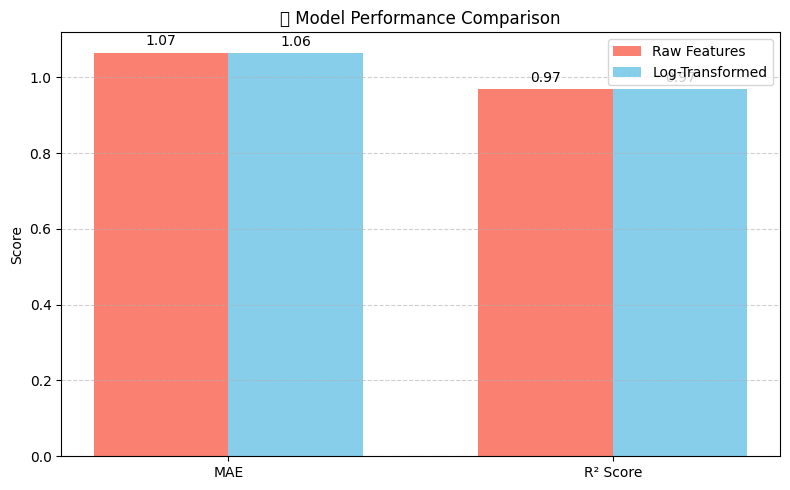

((1.0651952822385788, 0.9684002313527196),
 (1.0628236812757896, 0.9684914625539202))

In [15]:
# ---------- Visualization ----------
metrics = ["MAE", "R² Score"]
raw_scores = [mae_raw, r2_raw]
log_scores = [mae_log, r2_log]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, raw_scores, width, label='Raw Features', color='salmon')
bars2 = ax.bar(x + width/2, log_scores, width, label='Log-Transformed', color='skyblue')

ax.set_ylabel("Score")
ax.set_title("📊 Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.bar_label(bars1, fmt="%.2f", padding=3)
ax.bar_label(bars2, fmt="%.2f", padding=3)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

(mae_raw, r2_raw), (mae_log, r2_log)

**Conclusion:**

  * Log-tranforming skewed predictors like GDP, Alcohol, HIV/AIDS, Infant Deaths, Under-five Deaths helped normalize their distribution and slightly stablized model performance.
  * Both versions performed comparably, but transformed model is preferred for robustness.


**Model Comparison**

In [19]:

comparison_df = pd.DataFrame({
    "Model": ["Raw Features", "Log-Transformed Features"],
    "R² Score": [r2_raw, r2_log],
    "MAE": [mae_raw, mae_log]
})

comparison_df.style.set_caption("🔍 Model Performance Comparison").format({
    "R² Score": "{:.4f}",
    "MAE": "{:.2f}"
})

,Model,R² Score,MAE
0,Raw Features,0.9684,1.07
1,Log-Transformed Features,0.9685,1.06


**Conclusion:**

* Both models perform very well with R² scores above 0.96 and low MAE values.
* The log-transformed feature model slightly outperforms the raw feature model,  achieving an R² of 0.9685 and a slightly lower MAE of 1.06.
* This suggests that log-transforming skewed variables like GDP and HIV/AIDS helped the model capture nonlinear patterns more effectively.


Based on this, the log-transformed model was selected for SHAP analysis and final evaluation

###Step 8: Feature Importance From Final Model

To check which variables contribute most to predicting Life Expectancy.

<ipython-input-16-f021b7dca3a2>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




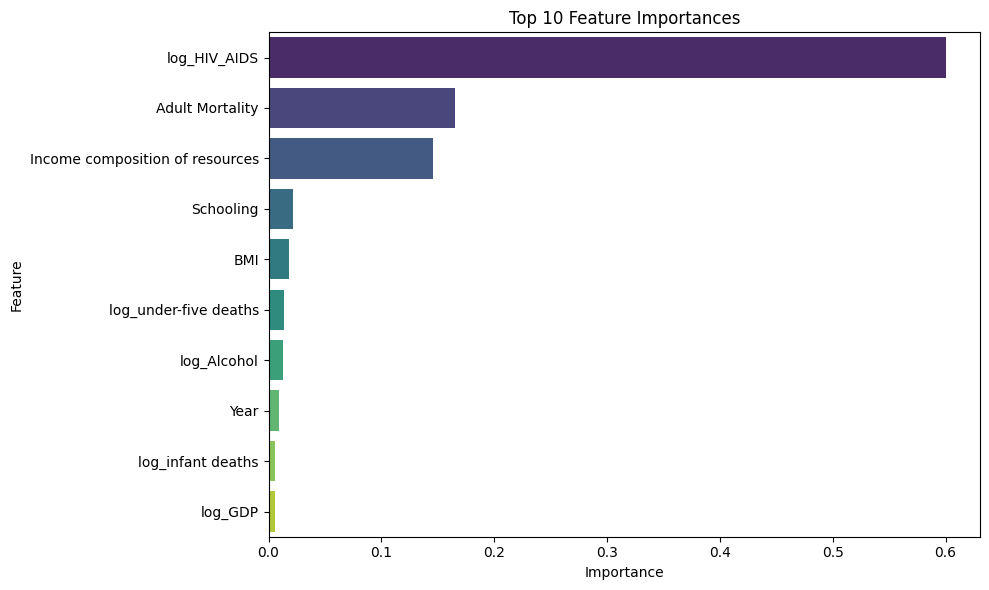

In [16]:

importances = model_log.feature_importances_
feature_names = features_log.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


**Conclusion:**

* Countries with **higher HIV/AIDS** rates consistently show lower life expectancy, suggesting the urgent need to disease control, awareness, and access to antiretroviral treatment.
* **Adult Mortality**, directly reflects the burden of premature deaths due to chronic disease, violence, or poor health infrastructure.
    * A high Adult Mortality rate significantly lowers national average life expectancy, emphasizing the need for preventing care and medical access, particularly in the developing countries.
* **Schooling** emerged as a crucial socioeconomic determinant, affirming that education indirectly boosts life expectancy by improving health awareness, access to opportunities, and economic conditions.
* **BMI and Log_under-five Deaths** aligns with basic healthcare, sanitation quality, reflecting how early-childhood survival is still a key life expectancy indicator in some regions.
* Lesser but notable features like Log_GDP, log_Alcohol and Status suggest that while wealth and development levels matter, they are secondary compared to direct health and mortality metrics in the dataset.




> *To raise life expectancy, coutries should prioritize tackling infectious disease burden and reducing adult mortality through health education, prevention programs, access to care.*



###Step 9: SHAP (SHapley Additive exPlanations)

* To better understand how each feature contributes to the model's prediction, SHAP (SHapley Additive exPlanations) was used.
* SHAP not only ranks features globally by their average contribution but also shows how high or low values of a feature impact individual predictions.


Two visualizations:

1. Bar Plot → Average impact of each feature across all predictions

2. Dot Plot → Direction and strength of impact for each observation


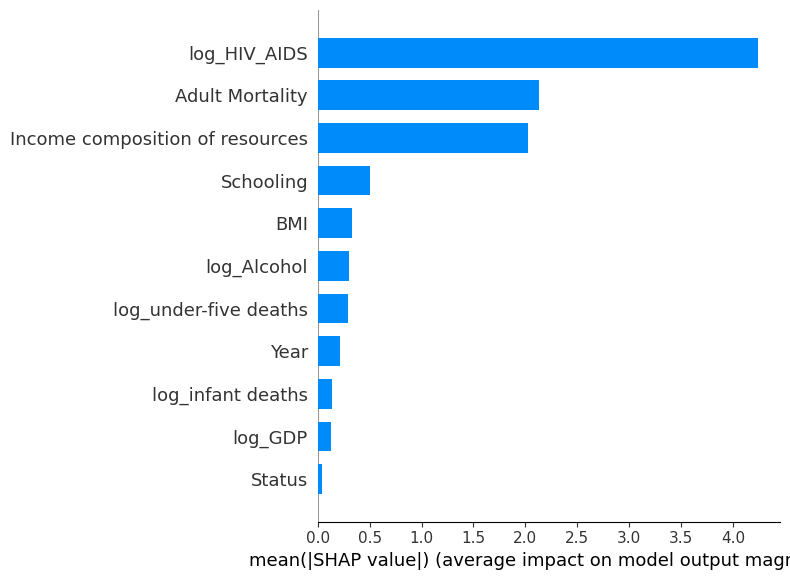

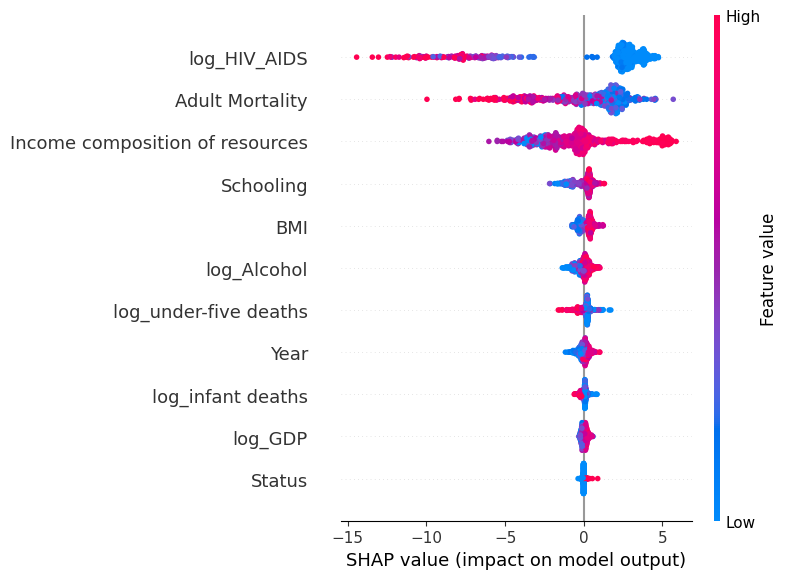

In [17]:
import shap

explainer = shap.TreeExplainer(model_log)
shap_values = explainer.shap_values(X_test_log)

# Summary bar plot
shap.summary_plot(shap_values, X_test_log, plot_type="bar")

# Summary dot plot (individual-level insight)
shap.summary_plot(shap_values, X_test_log)

**Conclusion:**

*  log_HIV_AIDS — Most Dominant Feature
   * SHAP showed this had the largest negative effect on life expectancy.
   * High HIV/AIDS prevalence (blue dots on left) drastically reduces predictions.

* Adult Mortality
   * Strongly negatively correlated.
   * Higher adult mortality = lower predicted life expectancy.

* Schooling
  * Positively impacts life expectancy — longer average schooling → longer lives.
  * Indicates education influences health knowledge, lifestyle, and income.

* BMI and Status - These features had more varied effects:
  * Medium BMI is good; too low or high may reduce life expectancy.
  * Status (developed/developing) affects predictions based on context — not always consistently.

* Other Features (e.g., GDP, Alcohol)
  * log_GDP had a relatively small direct impact once disease and mortality were accounted for.
  * log_Alcohol showed minor, slightly negative impact — possibly correlated with health behaviors.

###Step 10: Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_log, features_log, target, cv=5, scoring='r2')
print("Cross-validated R² Score:", cv_scores.mean())

Cross-validated R² Score: 0.9194472538535992


**Conclusion:**

* The 5-fold cross-validation yielded a strong average R² score is 0.91945.
* This confirms that the model performs consistently well across different subsets of the data and is not overly dependent on any specific train-test split.
* Such a result increases confidence in the model's robustness and it's ability to generalize to unseen life expectancy scenarios across different countries and years.

###Step 11: Trend Analysis Over Time

Analysis explores how global life expectancy has evolved from year to year.

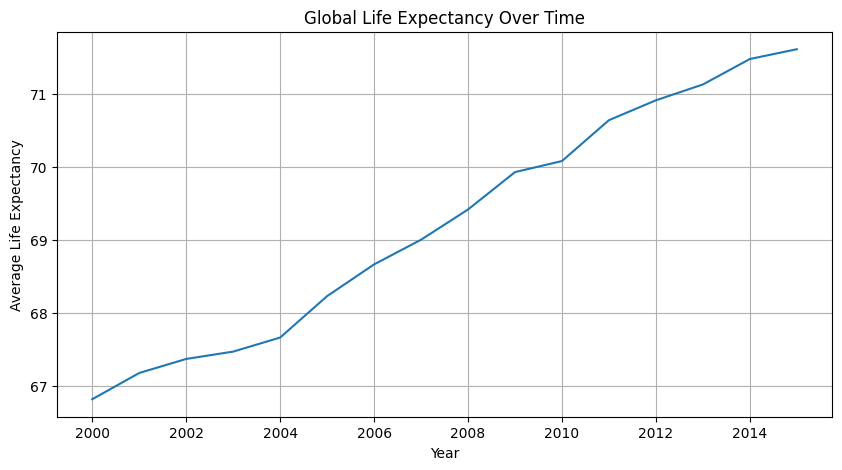

In [ ]:
plt.figure(figsize=(10, 5))
df_cleaned.groupby("Year")["Life expectancy"].mean().plot()
plt.title("Global Life Expectancy Over Time")
plt.xlabel("Year")
plt.ylabel("Average Life Expectancy")
plt.grid(True)
plt.show()

**Conclusion:**

* The line plot reveals a clear and consistent increase in global life expectancy between 2000 and 2015, rising from approximately 67 to over 71 years on average.
* This upward trend reflects significant progress in public health, healthcare access, and socioeconomic development worldwide.

###Step 12: Residual Analysis

* Residual analysis is performed to examine the difference between the actual and predicted life expectancy values.
* This helps detect any systematic errors or bias in the model.

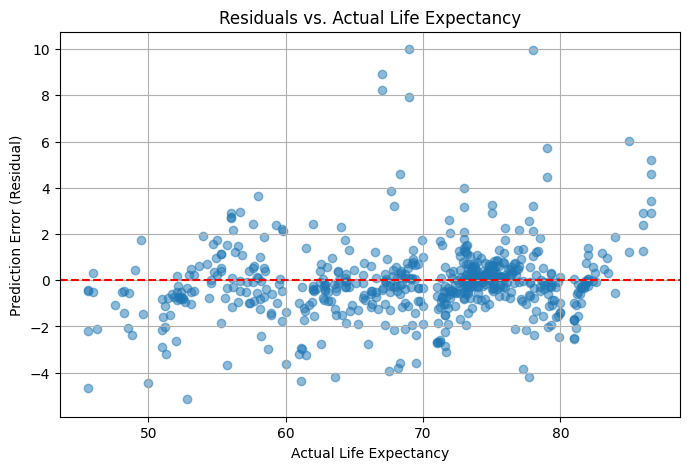

In [ ]:
residuals = y_test - pred_log
plt.figure(figsize=(8, 5))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Actual Life Expectancy")
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Prediction Error (Residual)")
plt.grid(True)
plt.show()


**Conclusion:**

* The residual plot shows that the prediction errors are generally centered around zero across the life expectancy range.
* Most residuals fall within ±3 years, indicating high prediction accuracy.
* There is no clear pattern or curvature, which suggests that the model does not suffer from major bias or heteroscedasticity.
* A few larger positive residuals are seen for predictions in the 65-75 range, indicating occasional underpredictions, but these are relatively rare and do not significantly affect model performance.






> Overall, the residuals validate that the model's predictions are reliable and consistent across different levels of life expectancy.



###**Final Conclusion - Life Expectancy Analysis**

This project successfully developed a robust, interpretable, and accurate machine learning model to predict Life Expectancy using global demographic and health data. After comprehensive data cleaning, outlier treatment, and feature engineering, both raw and log-transformed models were evaluated.

* The final Random Forest model with log-transformed features achieved outstanding performance with an R² score of 0.9685 and a mean absolute error (MAE) of 1.06 years, indicating excellent predictive accuracy.

* Cross-validation (R² = 0.919) confirmed that the model generalizes well and is not overly dependent on a particular data split.

* Feature importance and SHAP explainability revealed that HIV/AIDS prevalence, Adult Mortality, and Income Composition of Resources are the most influential factors affecting life expectancy. These findings align with global health priorities and validate the model’s reliability.

* Supporting analyses, such as residual plots, showed no significant bias, and trend analysis highlighted global improvements in life expectancy from 2000–2015.




> Overall, this project demonstrates how data science can be applied not only to make accurate predictions but also to provide meaningful public health insights. The model is well-suited for real-world use cases such as policy planning, resource allocation, and health strategy development.


